In [3]:
# Credit https://www.kaggle.com/code/ssakthisaravanan/nlp-r2-mbti-personality-predictor-using-ml

# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# Text Processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
MBTI_DS = pd.read_csv("mbti_1.csv")
MBTI_DS.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [5]:
MBTI_DS.shape

(8675, 2)

In [6]:
types = np.unique(np.array(MBTI_DS['type']))
print("The Unique values 'type' of personality column",types)

The Unique values 'type' of personality column ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


Text(0.5, 1.0, 'Total post each personality type')

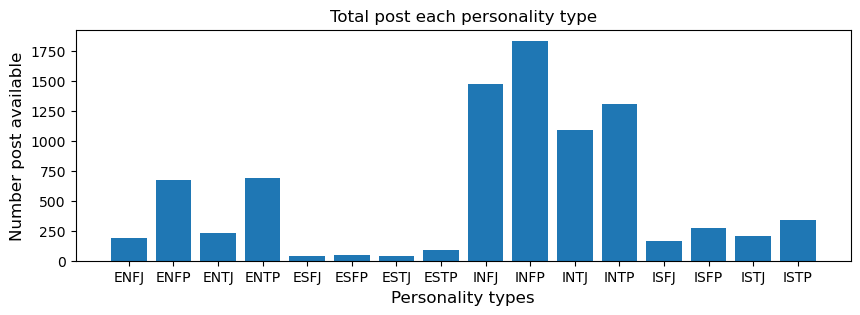

In [7]:
total = MBTI_DS.groupby(['type']).count()
plt.figure(figsize = (10,3))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 12)
plt.ylabel('Number post available', size = 12)
plt.title('Total post each personality type')

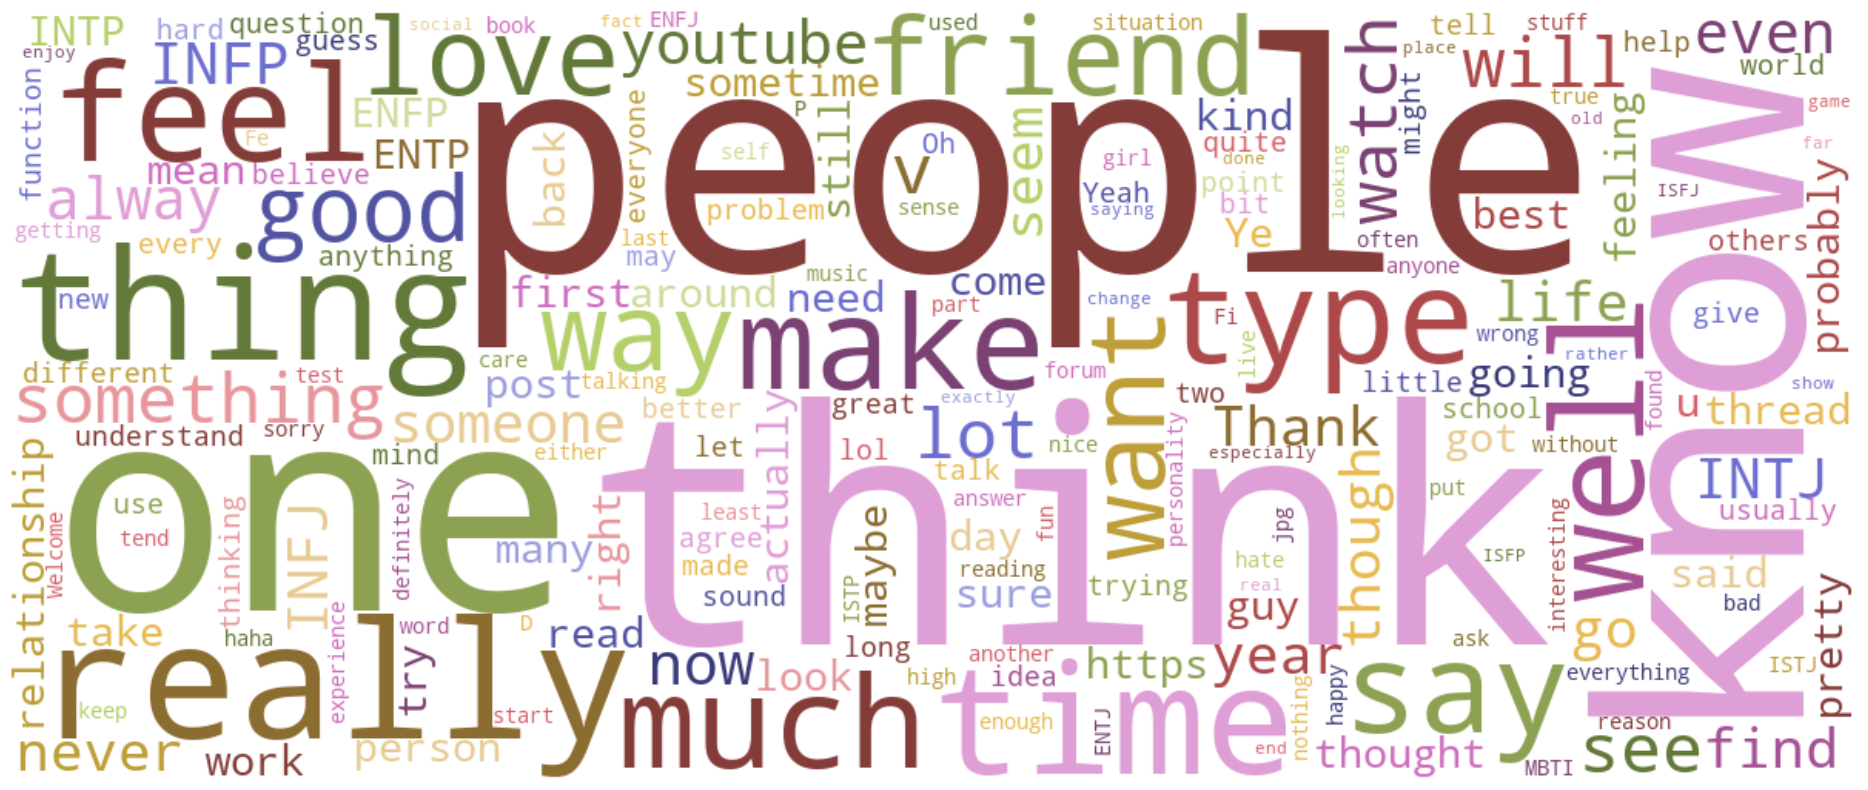

In [8]:
words = list(MBTI_DS["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
wc = wordcloud.WordCloud(width=1200, height=500, collocations=False, background_color="white", colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

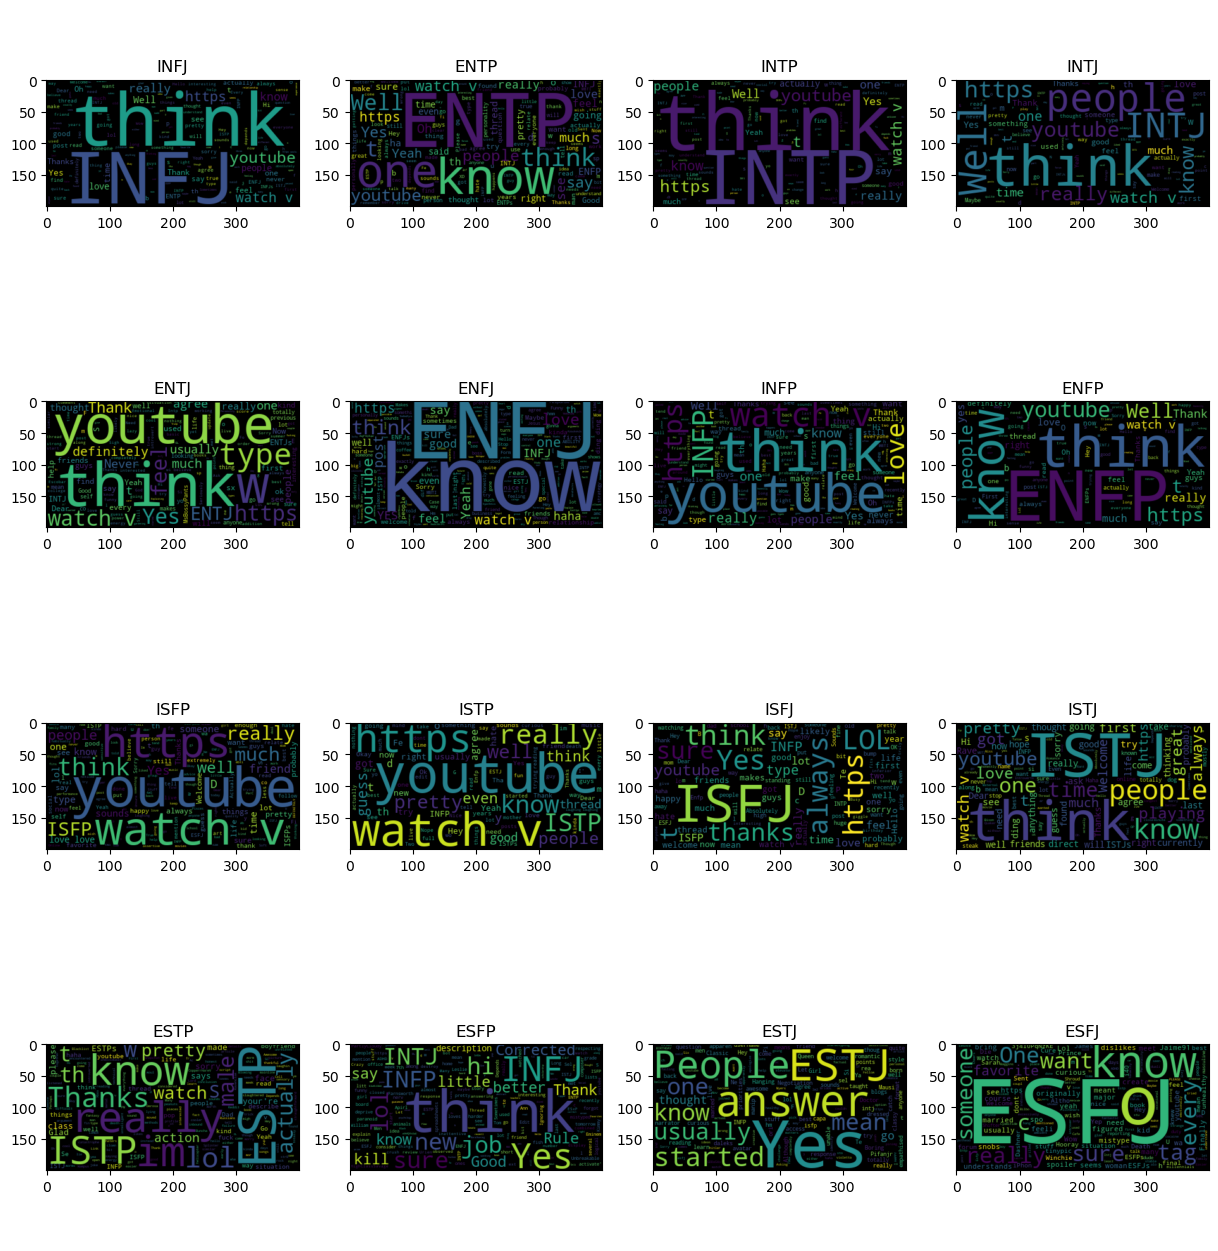

In [9]:
fig, ax = plt.subplots(len(MBTI_DS['type'].unique()), figsize=(15,len(MBTI_DS['type'].unique())))
k = 0
for i in MBTI_DS['type'].unique():
    df_4 = MBTI_DS[MBTI_DS['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [10]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0

    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found')

    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')

    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J })

MBTI_DS_N = MBTI_DS.join(MBTI_DS.apply (lambda row: get_types (row),axis=1))
MBTI_DS_N.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


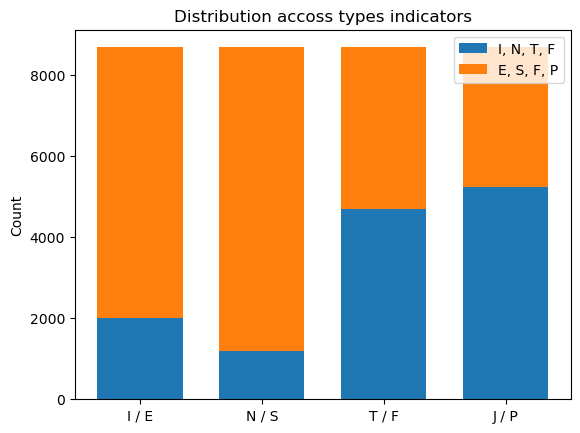

In [11]:
N = 4
bottom = (MBTI_DS_N['IE'].value_counts()[0], MBTI_DS_N['NS'].value_counts()[0], MBTI_DS_N['TF'].value_counts()[0], MBTI_DS_N['JP'].value_counts()[0])
top = (MBTI_DS_N['IE'].value_counts()[1], MBTI_DS_N['NS'].value_counts()[1], MBTI_DS_N['TF'].value_counts()[1], MBTI_DS_N['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P")

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

In [12]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

#Show result output for personality prediction
def translate_back(personality):
    # transform binary vector to MBTI personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in MBTI_DS_N.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
useless_words = stopwords.words("english")
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP','ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]
lemmatiser = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yaolanluo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yaolanluo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaolanluo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_MBTI_DS_N = len(MBTI_DS_N)
  i=0

  for row in MBTI_DS_N.iterrows():
      #Remove and clean comments
      posts = row[1].posts

      #Remove url links
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", MBTI_DS_N.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", MBTI_DS_N.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [15]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word",
                             max_features=1000,
                             max_df=0.7,
                             min_df=0.1)
# the feature should be made of word n-gram

# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


In [16]:
X = X_tfidf
Y = list_personality[:,]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
personality_type = [ "IE: Introversion (I) | Extroversion (E)", "NS: Intuition    (N) | Sensing      (S)",
                   "FT: Feeling      (F) | Thinking     (T)", "JP: Judging      (J) | Perceiving   (P)"  ]

In [17]:
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # fit model on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train,model.predict(X_train)))
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    print("\n")

IE: Introversion (I) | Extroversion (E) Accuracy: 77.91%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      4650
           1       0.73      0.13      0.22      1422

    accuracy                           0.79      6072
   macro avg       0.76      0.56      0.55      6072
weighted avg       0.77      0.79      0.72      6072

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      2026
           1       0.51      0.08      0.14       577

    accuracy                           0.78      2603
   macro avg       0.65      0.53      0.51      2603
weighted avg       0.73      0.78      0.71      2603



NS: Intuition    (N) | Sensing      (S) Accuracy: 85.86%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data


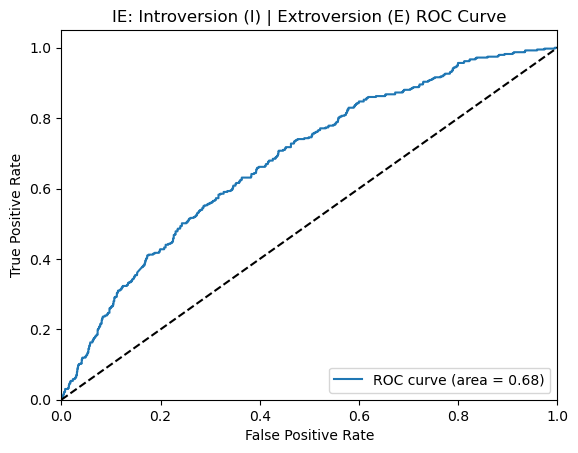

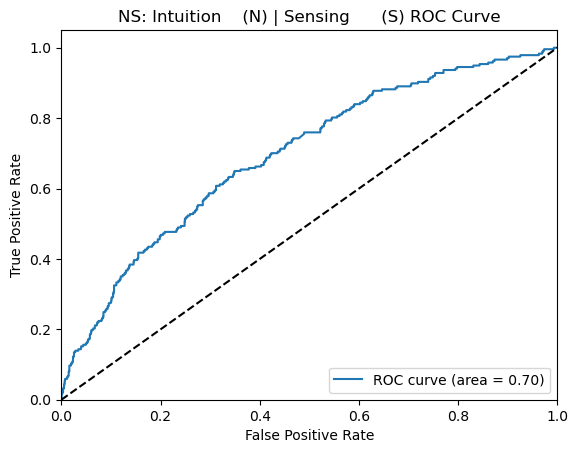

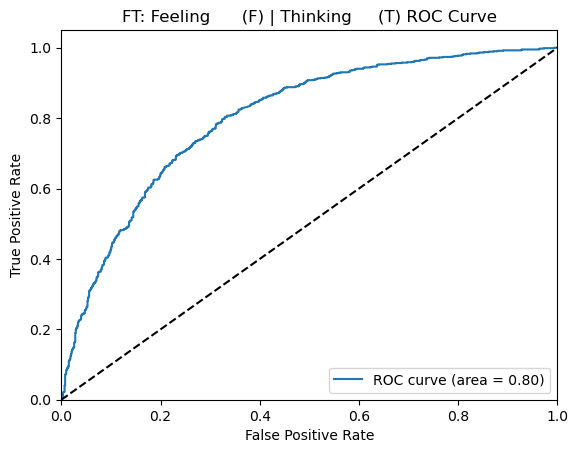

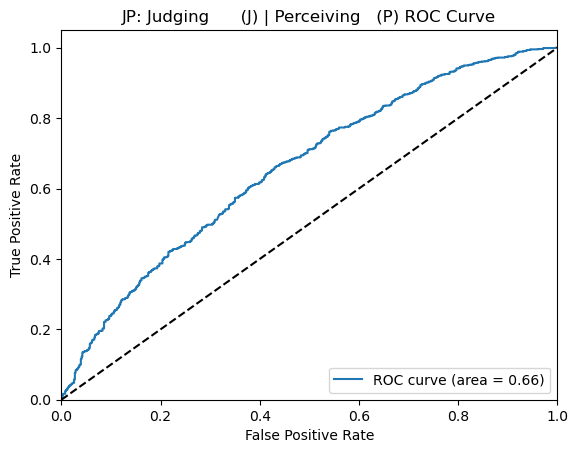

In [18]:
from sklearn.metrics import roc_curve, auc

for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

    # fit model on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict_proba(X_test)[:,1] # use predict_proba instead of predict for ROC curve

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('%s ROC Curve' % (personality_type[l]))
    plt.legend(loc="lower right")
    plt.show()

In [19]:
#KNN Classifier
from sklearn.metrics import accuracy_score,classification_report

# Tuning of K- value for Train & Test data
dummyarray = np.empty((5,3))
k_valchart = pd.DataFrame(dummyarray)
k_valchart.columns = ["K_value","Train_acc","Test_acc"]
k_vals = range(1, 10)
for i in range(len(k_vals)):
    knn_fit = KNeighborsClassifier(n_neighbors=k_vals[i])
    knn_fit.fit(X_train,y_train)
    print ("\nK-value",k_vals[i])
    tr_accscore = round(accuracy_score(y_train,knn_fit.predict(X_train)),3)
    print ("\nK-Nearest Neighbors - Train ConfusionMatrix\n\n",pd.crosstab( y_train, knn_fit.predict(X_train),rownames =["Actuall"],colnames = ["Predicted"]) )
    print ("\nK-Nearest Neighbors - Train accuracy:",tr_accscore)
    print ("\nK-Nearest Neighbors - Train Classification Report\n",classification_report(y_train,knn_fit.predict(X_train)))
    ts_accscore = round(accuracy_score(y_test,knn_fit.predict(X_test)),3)
    print ("\n\nK-Nearest Neighbors - Test Confusion Matrix\n\n",pd.crosstab( y_test,knn_fit.predict(X_test),rownames =["Actuall"],colnames = ["Predicted"]))
    print ("\nK-Nearest Neighbors - Test accuracy:",ts_accscore)
    print ("\nK-Nearest Neighbors - Test Classification Report\n",classification_report(y_test,knn_fit.predict(X_test)))
    k_valchart.loc[i, 'K_value'] = k_vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = ts_accscore


K-value 1

K-Nearest Neighbors - Train ConfusionMatrix

 Predicted     0     1
Actuall              
0          2744    27
1             0  4169

K-Nearest Neighbors - Train accuracy: 0.996

K-Nearest Neighbors - Train Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      2771
           1       0.99      1.00      1.00      4169

    accuracy                           1.00      6940
   macro avg       1.00      1.00      1.00      6940
weighted avg       1.00      1.00      1.00      6940



K-Nearest Neighbors - Test Confusion Matrix

 Predicted   0     1
Actuall            
0          57   606
1          66  1006

K-Nearest Neighbors - Test accuracy: 0.613

K-Nearest Neighbors - Test Classification Report
               precision    recall  f1-score   support

           0       0.46      0.09      0.15       663
           1       0.62      0.94      0.75      1072

    accuracy                           0.61

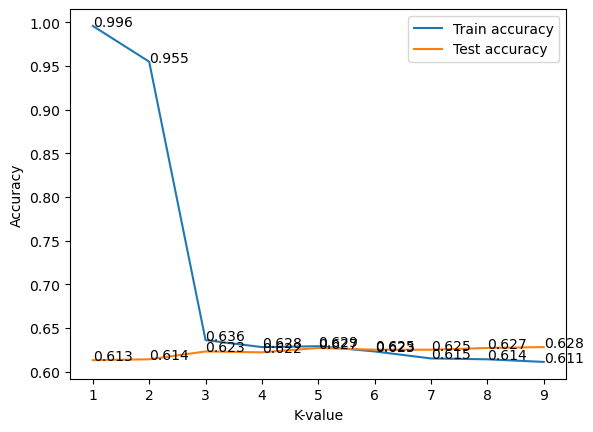

In [20]:
import matplotlib.pyplot as plt

# plot the train and test accuracy scores for different K-values
plt.plot(k_valchart['K_value'], k_valchart['Train_acc'], label='Train accuracy')
plt.plot(k_valchart['K_value'], k_valchart['Test_acc'], label='Test accuracy')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.xticks(k_valchart['K_value'])
plt.xticks(k_vals)
for a,b in zip(k_valchart["K_value"],k_valchart["Train_acc"]):
    plt.text(a, b, str(b),fontsize=10)
for a,b in zip(k_valchart["K_value"],k_valchart["Test_acc"]):
    plt.text(a, b, str(b),fontsize=10)
plt.legend()
plt.show()

# Now use a Random Forest on the dataset:

In [21]:
# Use MBTI personality to build a single model
list_personality_full = []
for row in MBTI_DS_N.iterrows():
    list_personality_full.append(row[1].type)
list_personality_full = np.array(list_personality_full)
list_personality_full[:8]

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'INTJ', 'INFJ', 'INTJ'],
      dtype='<U4')

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Apply Random Forest
Y = list_personality_full[:,]
personalities = ['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ']
for p in personalities:
    Y_NEW = []
    for i in range(len(Y)):
        Y_NEW.append(1 if Y[i]==p else 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y_NEW, test_size=0.3, random_state=0)

    clf = RandomForestClassifier(max_depth=4)
    clf.fit(X_train, y_train)
    print(p)
    # print(clf.score(X_test, y_test))

    tr_accscore = round(accuracy_score(y_train, clf.predict(X_train)), 4)
    # print ("\nRandom Forest - Train ConfusionMatrix\n\n",pd.crosstab( y_train, clf.predict(X_train),rownames =["Actuall"],colnames = ["Predicted"]) )
    print ("\nRandom Forest - Train accuracy:",tr_accscore)
    print ("Random Forest - Train Classification Report\n",classification_report(y_train,clf.predict(X_train)))
    ts_accscore = round(accuracy_score(y_test,clf.predict(X_test)),4)
    # print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab( y_test,clf.predict(X_test),rownames =["Actuall"],colnames = ["Predicted"]))
    print ("\nRandom Forest - Test accuracy:",ts_accscore)
    print ("Random Forest - Test Classification Report\n",classification_report(y_test,clf.predict(X_test)))

INFP

Random Forest - Train accuracy: 0.7875
Random Forest - Train Classification Report
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      4782
           1       0.00      0.00      0.00      1290

    accuracy                           0.79      6072
   macro avg       0.39      0.50      0.44      6072
weighted avg       0.62      0.79      0.69      6072


Random Forest - Test accuracy: 0.7918
Random Forest - Test Classification Report
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      2061
           1       0.00      0.00      0.00       542

    accuracy                           0.79      2603
   macro avg       0.40      0.50      0.44      2603
weighted avg       0.63      0.79      0.70      2603

INFJ

Random Forest - Train accuracy: 0.832
Random Forest - Train Classification Report
               precision    recall  f1-score   support

           0       0.83      

# Now use a bigger dataset with 100 thousand data

In [24]:
MBTI_DS_BIG = pd.read_csv("MBTI_500.csv")
MBTI_DS_BIG.tail()

,posts,type
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP
106066,feel like men good problem tell parent want te...,INFP


In [25]:
posts = []
labels = []
for row in MBTI_DS_BIG.iterrows():
    temp = row[1].posts

    # Remove MBTI words from posts
    for t in unique_type_list:
        temp = temp.replace(t,"")

    posts.append(temp)
    labels.append(row[1].type)

posts = np.array(posts)
labels = np.array(labels)

In [26]:
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_count = cntizer.fit_transform(posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_new_tfidf =  tfizer.fit_transform(X_count).toarray()
print(X_new_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'accept'), (4, 'accurate'), (5, 'across'), (6, 'act'), (7, 'action'), (8, 'activity'), (9, 'actual')]

Using Tf-idf :
Now the dataset size is as below
(106067, 681)


In [ ]:
X = X_new_tfidf
Y = labels

for p in personalities:
    Y_NEW = []
    for i in range(len(Y)):
        Y_NEW.append(1 if Y[i]==p else 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y_NEW, test_size=0.2, random_state=0)

    clf1 = RandomForestClassifier(max_depth=4)
    # clf2 = LogisticRegression()
    clf1.fit(X_train, y_train)
    # clf2.fit(X_train, y_train)
    print(p)
    # print("Random Forest: ", clf1.score(X_test, y_test))
    # print("Logistic Regression: ", clf2.score(X_test, y_test))
    trr = clf1.predict(X_train)
    tee = clf1.predict(X_test)
    tr_accscore = round(accuracy_score(y_train, trr), 4)
    # print ("\nRandom Forest - Train ConfusionMatrix\n\n",pd.crosstab( y_train, clf.predict(X_train),rownames =["Actuall"],colnames = ["Predicted"]) )
    print ("\nRandom Forest - Train accuracy:", tr_accscore)
    print ("Random Forest - Train Classification Report\n",classification_report(y_train,trr))
    ts_accscore = round(accuracy_score(y_test, tee),4)
    # print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab( y_test,clf.predict(X_test),rownames =["Actuall"],colnames = ["Predicted"]))
    print ("Random Forest - Test accuracy:",ts_accscore)
    print ("Random Forest - Test Classification Report\n",classification_report(y_test, tee))

INFP

Random Forest - Train accuracy: 0.8853
Random Forest - Train Classification Report
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     75120
           1       0.00      0.00      0.00      9733

    accuracy                           0.89     84853
   macro avg       0.44      0.50      0.47     84853
weighted avg       0.78      0.89      0.83     84853

Random Forest - Test accuracy: 0.8868
Random Forest - Test Classification Report
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18813
           1       0.00      0.00      0.00      2401

    accuracy                           0.89     21214
   macro avg       0.44      0.50      0.47     21214
weighted avg       0.79      0.89      0.83     21214

INFJ

Random Forest - Train accuracy: 0.8587
Random Forest - Train Classification Report
               precision    recall  f1-score   support

           0       0.86      

# After Undersampling

In [ ]:
total = MBTI_DS_BIG.groupby(['type']).count()
plt.figure(figsize=(10, 3))
plt.bar(np.array(total.index), height=total['posts'], )
plt.xlabel('Personality types', size=12)
plt.ylabel('Number post available', size=12)
plt.title('Total post each personality type')

In [ ]:
print(total)

In [ ]:
int((total.mean())[0])

In [ ]:
from sklearn.utils import resample

target_size = total.min()[0]

# Undersample each class to the target size
undersampled_data = pd.DataFrame()
for mbti_type, group in MBTI_DS_BIG.groupby('type'):
    undersampled_group = resample(group, replace=False, n_samples=target_size, random_state=42)
    undersampled_data = pd.concat([undersampled_data, undersampled_group])

# Shuffle the undersampled data
undersampled_data = undersampled_data.sample(frac=1, random_state=42)

In [ ]:
posts_undersampled = []
labels_undersampled = []
for row in undersampled_data.iterrows():
    temp = row[1].posts

    # Remove MBTI words from posts
    for t in unique_type_list:
        temp = temp.replace(t, "")

    posts_undersampled.append(temp)
    labels_undersampled.append(row[1].type)

posts_undersampled = np.array(posts_undersampled)
labels_undersampled = np.array(labels_undersampled)

In [ ]:
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_count_unders = cntizer.fit_transform(posts_undersampled)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names_unders = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names_unders[0:10])

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_new_tfidf_unders = tfizer.fit_transform(X_count_unders).toarray()
print(X_new_tfidf_unders.shape)

In [ ]:
X = X_new_tfidf_unders
Y = labels_undersampled

for p in personalities:
    Y_NEW = []
    for i in range(len(Y)):
        Y_NEW.append(1 if Y[i] == p else 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y_NEW, test_size=0.2, random_state=0)

    clf1 = RandomForestClassifier(max_depth=4)
    clf2 = LogisticRegression()
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    print(p)
    print("Random Forest: ", clf1.score(X_test, y_test))
    print("Logistic Regression: ", clf2.score(X_test, y_test))

In [ ]:
# For comparison purpose, we want to visualize 
# 'Performance Scores of Logistic Regression and Random Forest by MBTI Type' before resampling first


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Since the image contains tabular data, we will manually input the data based on the image provided.

# Data extracted from the image
data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "INFP": [0.887, 0.897],
    "INFJ": [0.886, 0.878],
    "INTP": [0.766, 0.8],
    "INTJ": [0.787, 0.817],
    "ENTP": [0.889, 0.906],
    "ENFP": [0.942, 0.944],
    "ISTP": [0.969, 0.97],
    "ISFP": [0.992, 0.992],
    "ENTJ": [0.971, 0.972],
    "ISTJ": [0.989, 0.989],
    "ENFJ": [0.985, 0.985],
    "ISFJ": [0.994, 0.994],
    "ESTP": [0.981, 0.987],
    "ESFP": [0.996, 0.996],
    "ESFJ": [0.998, 0.998],
    "ESTJ": [0.995, 0.996],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to make it suitable for a barplot
df_melted = df.melt(id_vars="Model", var_name="MBTI Type", value_name="Score")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Draw a barplot to show the score for each MBTI type by model
sns.barplot(x="MBTI Type", y="Score", hue="Model", data=df_melted)

# Improve the visuals
ax.set_title('Performance Scores of Logistic Regression and Random Forest by MBTI Type')
ax.set_ylabel('Score')
ax.set_xlabel('MBTI Type')
sns.despine(left=True, bottom=True)

# Rotate the x labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
# For comparison purpose, we want to visualize 
# 'Performance Scores of Logistic Regression and Random Forest by MBTI Type' before resampling first


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Since the image contains tabular data, we will manually input the data based on the image provided.

# Data extracted from the image
data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "INFP": [0.887, 0.897],
    "INFJ": [0.886, 0.878],
    "INTP": [0.766, 0.8],
    "INTJ": [0.787, 0.817],
    "ENTP": [0.889, 0.906],
    "ENFP": [0.942, 0.944],
    "ISTP": [0.969, 0.97],
    "ISFP": [0.992, 0.992],
    "ENTJ": [0.971, 0.972],
    "ISTJ": [0.989, 0.989],
    "ENFJ": [0.985, 0.985],
    "ISFJ": [0.994, 0.994],
    "ESTP": [0.981, 0.987],
    "ESFP": [0.996, 0.996],
    "ESFJ": [0.998, 0.998],
    "ESTJ": [0.995, 0.996],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to make it suitable for a barplot
df_melted = df.melt(id_vars="Model", var_name="MBTI Type", value_name="Score")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Draw a barplot to show the score for each MBTI type by model
sns.barplot(x="MBTI Type", y="Score", hue="Model", data=df_melted)

# Improve the visuals
ax.set_title('Performance Scores of Logistic Regression and Random Forest by MBTI Type')
ax.set_ylabel('Score')
ax.set_xlabel('MBTI Type')
sns.despine(left=True, bottom=True)

# Rotate the x labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()
